In [1]:
import os 
import torch 
import torch.nn as nn 
import torch.nn.functional as F

import torchvision
import torchvision.transforms as transforms
import time 
from torchvision.utils import save_image
from torch.utils.data import Dataset
from  torchinfo import summary 
import torchsummary
import time

c:\Users\sim2real\AppData\Local\miniconda3\envs\fish\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:

# setting 
EPOCHS = 200 
BATCH_SIZE = 100 
LEARNING_RATE = 0.0002
IMAGE_SIZE = 28
IMAGE_CHANNEL = 1 
LATENT_DIM = 100 # 28*28 = 784가 아닌데?

DIRECTORY_NAME = "./ConditionalGAN_Result"

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using Device {DEVICE}")
# Result Directory 
if not os.path.exists(DIRECTORY_NAME):
    os.makedirs(DIRECTORY_NAME)

Using Device cuda


# DATASET

Train data path: ./dataset/Fashion-MNIST/fashion-mnist_train.csv
Valid data path: ./dataset/Fashion-MNIST/fashion-mnist_test.csv
Image size: (60000, 28, 28)
--- Label ---
label
2    6000
9    6000
6    6000
0    6000
3    6000
4    6000
5    6000
8    6000
7    6000
1    6000
Name: count, dtype: int64
<PIL.Image.Image image mode=L size=28x28 at 0x1CAA1B667F0>
Ankle boot


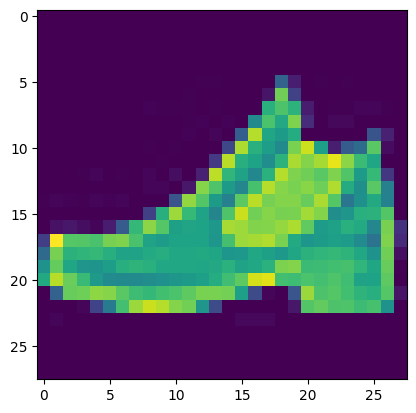

In [3]:
%matplotlib inline
from matplotlib.pyplot import imshow

import pandas as pd
import numpy as np
from PIL import Image

train_data_path = './dataset/Fashion-MNIST/fashion-mnist_train.csv' # Path of data
valid_data_path = './dataset/Fashion-MNIST/fashion-mnist_test.csv' # Path of data
print('Train data path:', train_data_path)
print('Valid data path:', valid_data_path)

class_list = ['T-Shirt', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
class_num = len(class_list)

transforms_train = transforms.Compose([
    transforms.Resize(28),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])


class FashionMNIST(Dataset):
    def __init__(self, path, img_size, transform=None):
        self.transform = transform
        fashion_df = pd.read_csv(path)
        self.images = fashion_df.iloc[:, 1:].values.astype('uint8').reshape(-1, img_size, img_size)
        self.labels = fashion_df.label.values
        print('Image size:', self.images.shape)
        print('--- Label ---')
        print(fashion_df.label.value_counts())

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        label = self.labels[idx]
        img = self.images[idx]
        img = Image.fromarray(self.images[idx])
            
        if self.transform:
            img = self.transform(img)
        
        return img, label
    


dataset = FashionMNIST(train_data_path, IMAGE_SIZE,transform=None)
imshow(dataset[1][0])
print(dataset[1][0])
print(class_list[dataset[1][1]])


In [4]:

dataset = FashionMNIST(train_data_path,IMAGE_SIZE,transform=transforms_train)
data_loader = torch.utils.data.DataLoader(dataset,batch_size=BATCH_SIZE,shuffle=True)

Image size: (60000, 28, 28)
--- Label ---
label
2    6000
9    6000
6    6000
0    6000
3    6000
4    6000
5    6000
8    6000
7    6000
1    6000
Name: count, dtype: int64


# Discriminator 

In [5]:
class Discriminator(nn.Module):
    def __init__(self) -> None:
        super(Discriminator,self).__init__()
    
        self.linear_layer = []
        self.model = nn.Sequential(
            nn.Linear(IMAGE_CHANNEL*IMAGE_SIZE*IMAGE_SIZE+class_num,1024),
            nn.LeakyReLU(0.2,inplace=True),
            nn.Dropout(0.3),
            nn.Linear(1024,512),
            nn.LeakyReLU(0.2,inplace=True),
            nn.Dropout(0.3),
            nn.Linear(512,256),
            nn.LeakyReLU(0.2,inplace=True),
            nn.Dropout(0.3),
            nn.Linear(256,1),
            nn.Sigmoid()
        )
    def forward(self,x,labels):
        x = x.view(BATCH_SIZE,IMAGE_SIZE*IMAGE_SIZE*IMAGE_CHANNEL)
        label = F.one_hot(labels, num_classes=class_num)
        real_image_label = torch.cat([x,label],1)
        out = self.model(real_image_label)

        return out
    


discriminator = Discriminator().to(DEVICE)


# Generator

In [6]:
class Generator(nn.Module):
    def __init__(self) -> None:
        super(Generator,self).__init__()

        self.model = nn.Sequential(
            nn.Linear(LATENT_DIM+class_num,256),
            nn.LeakyReLU(0.2,inplace=True),
            nn.Linear(256,512),
            nn.LeakyReLU(0.2,inplace=True),
            nn.Linear(512,1024),
            nn.LeakyReLU(0.2,inplace=True),
            nn.Linear(1024,IMAGE_CHANNEL*IMAGE_SIZE*IMAGE_SIZE),
            nn.Tanh()
        )
    def forward(self,z,labels):
        z = z.view(-1,LATENT_DIM)
        c = F.one_hot(labels,num_classes=class_num)
        # print(z.size(),c.size())
        x = torch.cat([z,c],1)
        out = self.model(x)
        return out.view(-1,IMAGE_CHANNEL,IMAGE_SIZE,IMAGE_SIZE)
    
generator = Generator().to(DEVICE)

In [7]:
adversarial_loss = nn.BCELoss()

g_optimizer = torch.optim.Adam(generator.parameters(), lr=LEARNING_RATE)
d_optimizer = torch.optim.Adam(discriminator.parameters(), lr=LEARNING_RATE)

In [8]:
# start_time = time.time()
# for epoch in range(EPOCHS):
#     #print('Starting epoch {}...'.format(epoch+1))
#     for i,(images,labels) in enumerate(data_loader):
#         real_imgs = images.to(DEVICE)
#         real_labels = labels.to(DEVICE)

#         discriminator_label = torch.cuda.FloatTensor(BATCH_SIZE,1).fill_(1.0)
#         generator_label =torch.cuda.FloatTensor(BATCH_SIZE,1).fill_(0.0)
#         # discriminator Train 
#         d_optimizer.zero_grad()
#         real_validity = discriminator(real_imgs,real_labels)
#         D_loss = adversarial_loss(real_validity,discriminator_label)

#         latent_vector = torch.normal(mean = 0,std =1,size=(BATCH_SIZE,LATENT_DIM)).to(DEVICE)
#         fake_labels = torch.LongTensor(np.random.randint(0,class_num,BATCH_SIZE)).to(DEVICE)

#         fake_images = generator(latent_vector,fake_labels)
#         #print(fake_images.size())
#         G_loss = adversarial_loss(discriminator(fake_images.detach(),fake_labels),generator_label)

#         t_loss = (D_loss + G_loss) /2 
#         t_loss.backward()
#         d_optimizer.step()

#         g_optimizer.zero_grad()
#         fake_images = generator(latent_vector,fake_labels)
#         G_loss = adversarial_loss(discriminator(fake_images,fake_labels),discriminator_label)
#         G_loss.backward()
#         g_optimizer.step()
#         done = epoch* len(data_loader)+i
#         if done % 12000 == 0:
#             save_image(fake_images.data[:9],f"{DIRECTORY_NAME}/{epoch}_epoch.png",nrow = 3,normalize = True)

#     generator.eval()

#     print(f"[Epoch {epoch}/{EPOCHS}] [D loss:{t_loss.item():.6f}] [G loss: {G_loss.item():.6f}]\
#           [Elapsed time: {time.time() - start_time:.2f}s]")
#     if epoch % 10 == 0:
#         latent_vector = torch.normal(mean = 0,std =1,size=(class_num-1,LATENT_DIM)).to(DEVICE)
#         labels =torch.LongTensor(np.arange(0,class_num-1)).to(DEVICE) # 0~9까지 순차적으로 형성된 라벨 
#         sample_images = generator(latent_vector, labels).data.cpu()
#         print(labels)
#         save_image(sample_images.data[:],f"{DIRECTORY_NAME}/{epoch}_epoch.png",nrow = 3,normalize = True)

# # fake_label을 전혀 사용하지 않고 작성해 보자 


In [9]:
DIRECTORY_NAME = "./ConditionalGAN_Result_label_fix_ver"
if not os.path.exists(DIRECTORY_NAME):
    os.makedirs(DIRECTORY_NAME)
start_time = time.time()
for epoch in range(EPOCHS):
    #print('Starting epoch {}...'.format(epoch+1))
    for i,(images,labels) in enumerate(data_loader):
        real_imgs = images.to(DEVICE)
        real_labels = labels.to(DEVICE)

        discriminator_label = torch.cuda.FloatTensor(BATCH_SIZE,1).fill_(1.0)
        generator_label =torch.cuda.FloatTensor(BATCH_SIZE,1).fill_(0.0)
        # discriminator Train 
        d_optimizer.zero_grad()
        real_validity = discriminator(real_imgs,real_labels)
        D_loss = adversarial_loss(real_validity,discriminator_label)

        latent_vector = torch.normal(mean = 0,std =1,size=(BATCH_SIZE,LATENT_DIM)).to(DEVICE)
        fake_labels = torch.LongTensor(np.random.randint(0,class_num,BATCH_SIZE)).to(DEVICE)

        fake_images = generator(latent_vector,real_labels)
        #print(fake_images.size())
        G_loss = adversarial_loss(discriminator(fake_images.detach(),real_labels),generator_label)

        t_loss = (D_loss + G_loss) /2 
        t_loss.backward()
        d_optimizer.step()

        g_optimizer.zero_grad()
        fake_images = generator(latent_vector,real_labels)
        G_loss = adversarial_loss(discriminator(fake_images,real_labels),discriminator_label)
        G_loss.backward()
        g_optimizer.step()
        done = epoch* len(data_loader)+i
        if done % 12000 == 0:
            save_image(fake_images.data[:9],f"{DIRECTORY_NAME}/{epoch}_epoch.png",nrow = 3,normalize = True)

    generator.eval()

    print(f"[Epoch {epoch}/{EPOCHS}] [D loss:{t_loss.item():.6f}] [G loss: {G_loss.item():.6f}]\
          [Elapsed time: {time.time() - start_time:.2f}s]")
    if epoch % 10 == 0:
        latent_vector = torch.normal(mean = 0,std =1,size=(class_num-1,LATENT_DIM)).to(DEVICE)
        labels =torch.LongTensor(np.arange(0,class_num-1)).to(DEVICE) # 0~9까지 순차적으로 형성된 라벨 
        sample_images = generator(latent_vector, labels).data.cpu()
        print(labels)
        save_image(sample_images.data[:],f"{DIRECTORY_NAME}/{epoch}_epoch.png",nrow = 3,normalize = True)

# fake_label을 전혀 사용하지 않고 대신 실제 라벨을 넘겨주는 걸로 변경 


[Epoch 0/200] [D loss:0.087845] [G loss: 4.819378]          [Elapsed time: 13.90s]
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')
[Epoch 1/200] [D loss:0.370737] [G loss: 2.682072]          [Elapsed time: 26.41s]
[Epoch 2/200] [D loss:0.095889] [G loss: 3.582614]          [Elapsed time: 39.41s]
[Epoch 3/200] [D loss:0.217362] [G loss: 3.220568]          [Elapsed time: 52.25s]
[Epoch 4/200] [D loss:0.265066] [G loss: 2.945384]          [Elapsed time: 64.99s]
[Epoch 5/200] [D loss:0.400218] [G loss: 2.467254]          [Elapsed time: 77.56s]
[Epoch 6/200] [D loss:0.438059] [G loss: 2.172454]          [Elapsed time: 89.99s]
[Epoch 7/200] [D loss:0.422760] [G loss: 1.613439]          [Elapsed time: 102.87s]
[Epoch 8/200] [D loss:0.352496] [G loss: 1.769679]          [Elapsed time: 115.65s]
[Epoch 9/200] [D loss:0.341933] [G loss: 1.822399]          [Elapsed time: 128.13s]
[Epoch 10/200] [D loss:0.428327] [G loss: 1.583353]          [Elapsed time: 140.62s]
tensor([0, 1, 2, 3, 4, 5, 6, 